### Improting the .csv file

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.tsatools import detrend
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

In [2]:
df = pd.read_csv("DailyDelhiClimate.csv")
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df = df.sort_index()

In [3]:
print(df.isnull().sum())

meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64


In [4]:
df.head()

meantemp   humidity  wind_speed  meanpressure
date                                                      
2013-01-01  10.000000  84.500000    0.000000   1015.666667
2013-01-02   7.400000  92.000000    2.980000   1017.800000
2013-01-03   7.166667  87.000000    4.633333   1018.666667
2013-01-04   8.666667  71.333333    1.233333   1017.166667
2013-01-05   6.000000  86.833333    3.700000   1016.500000

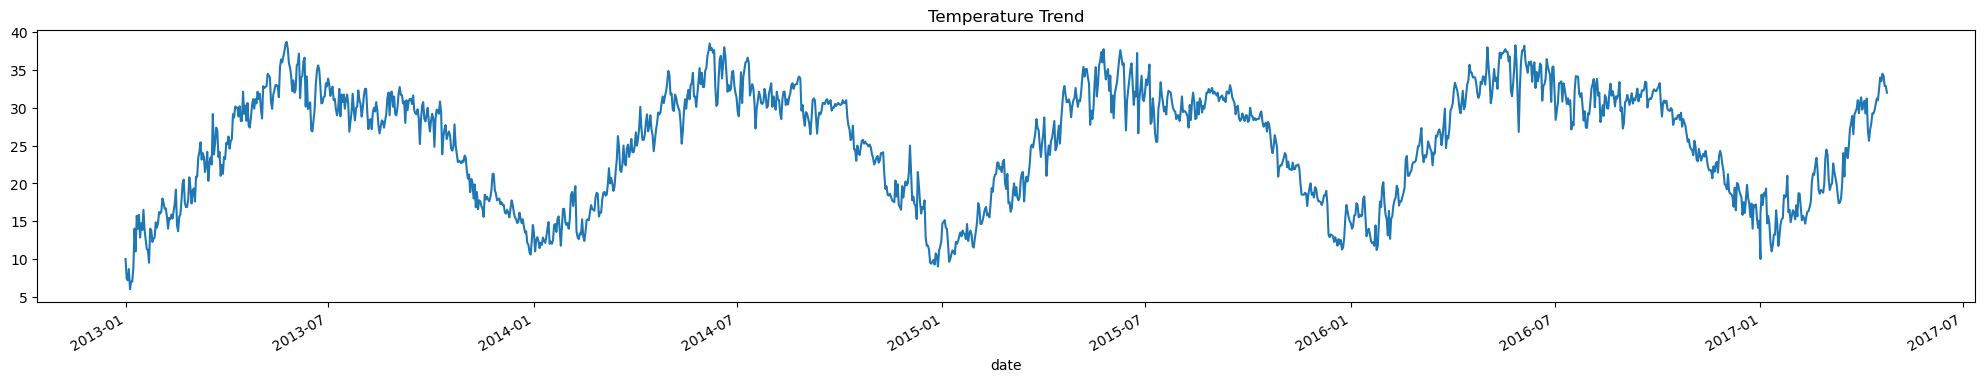

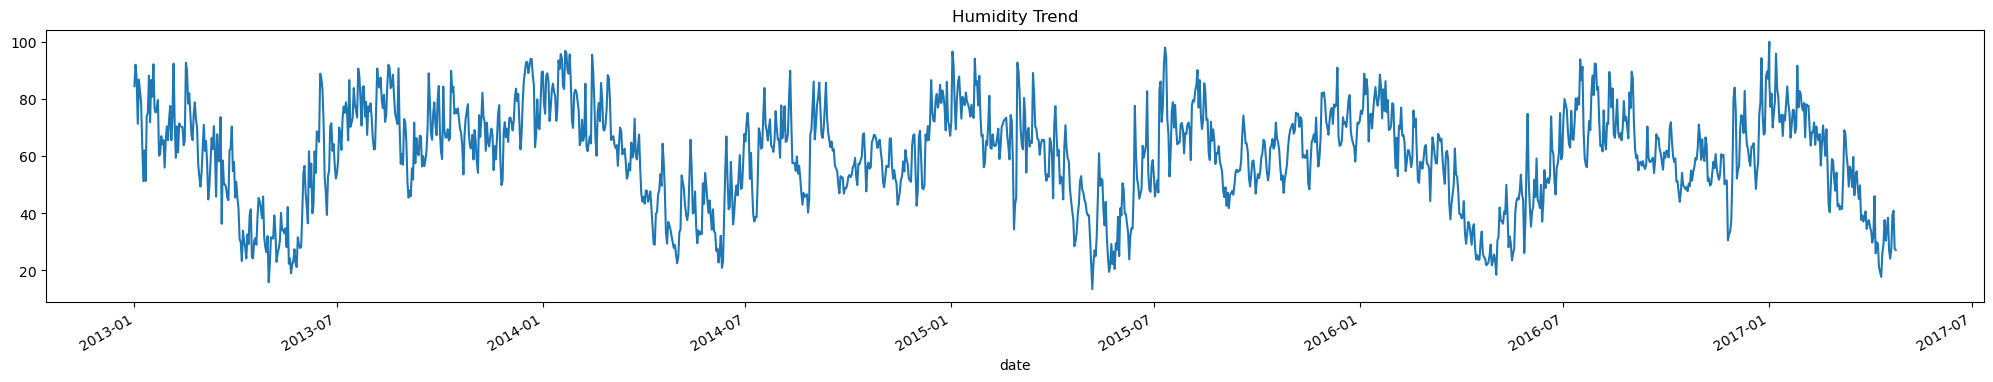

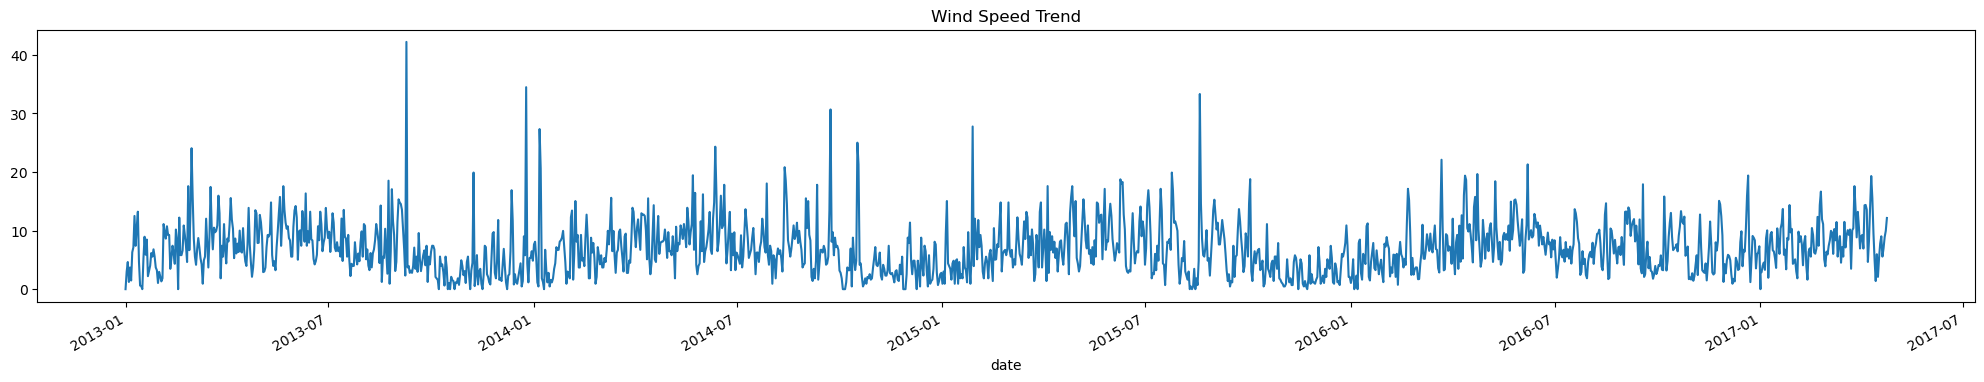

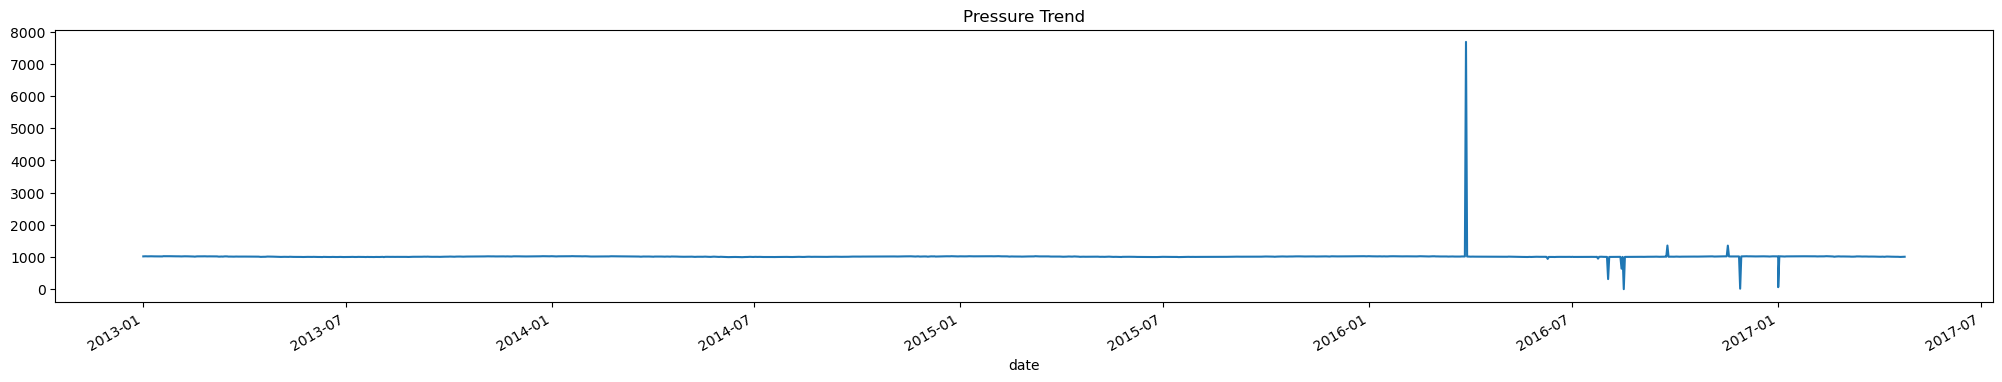

In [5]:
df['meantemp'].plot(figsize=(25,4), title = "Temperature Trend")
plt.show()

df['humidity'].plot(figsize=(25,4), title="Humidity Trend")
plt.show()

df['wind_speed'].plot(figsize=(25,4), title="Wind Speed Trend")
plt.show()

df['meanpressure'].plot(figsize=(25,4), title="Pressure Trend")
plt.show()

# Handle the wrong value in the pressure sensor value

7679.333333333333
2016-03-28 00:00:00
meantemp          26.25000
humidity          53.68750
wind_speed         9.15625
meanpressure    1012.81250
Name: 2016-03-27 00:00:00, dtype: float64
meantemp          25.933333
humidity          52.800000
wind_speed         6.546667
meanpressure    7679.333333
Name: 2016-03-28 00:00:00, dtype: float64
meantemp          27.12500
humidity          47.75000
wind_speed         7.29375
meanpressure    1011.31250
Name: 2016-03-29 00:00:00, dtype: float64
meantemp        25.933333
humidity        52.800000
wind_speed       6.546667
meanpressure          NaN
Name: 2016-03-28 00:00:00, dtype: float64
meantemp          25.933333
humidity          52.800000
wind_speed         6.546667
meanpressure    1012.062500
Name: 2016-03-28 00:00:00, dtype: float64


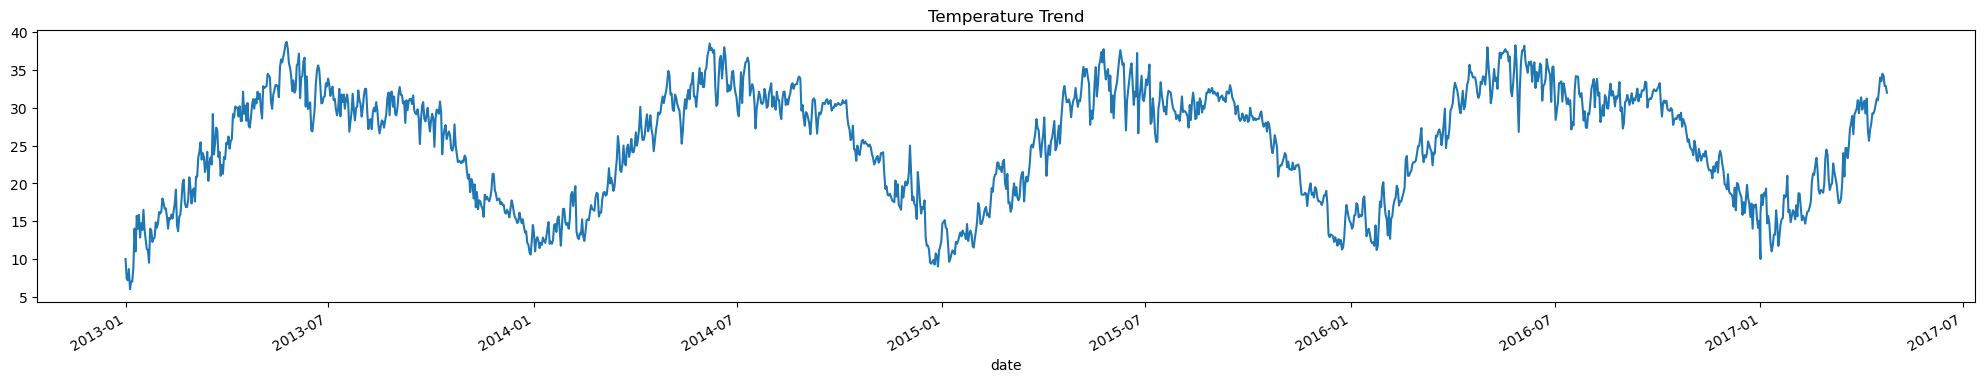

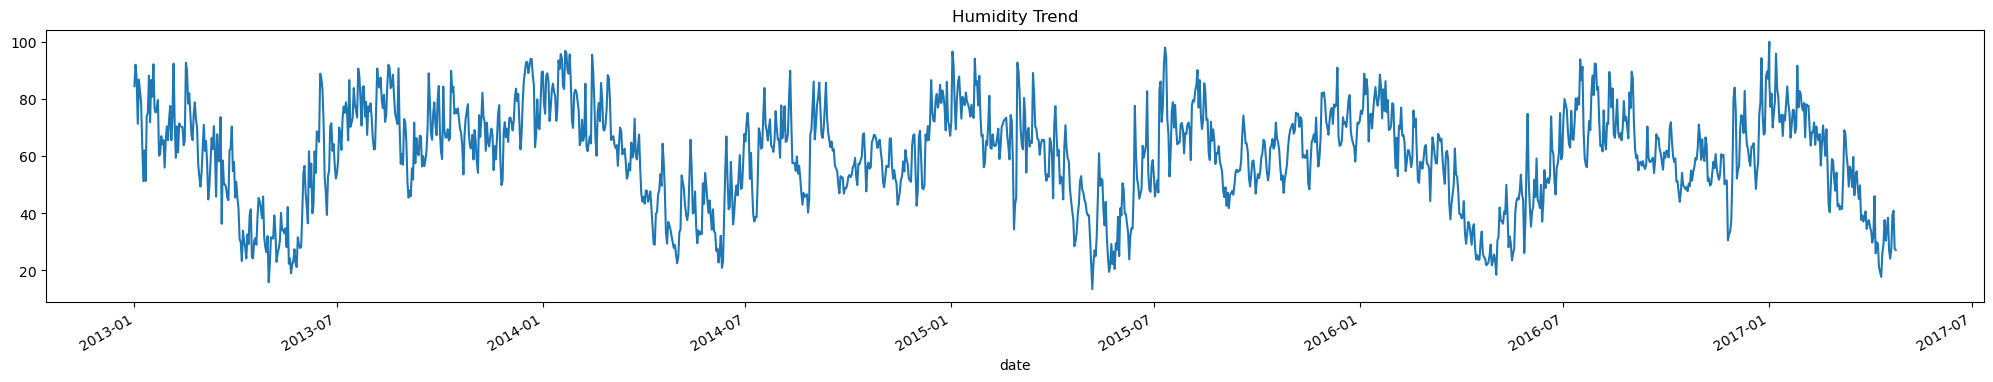

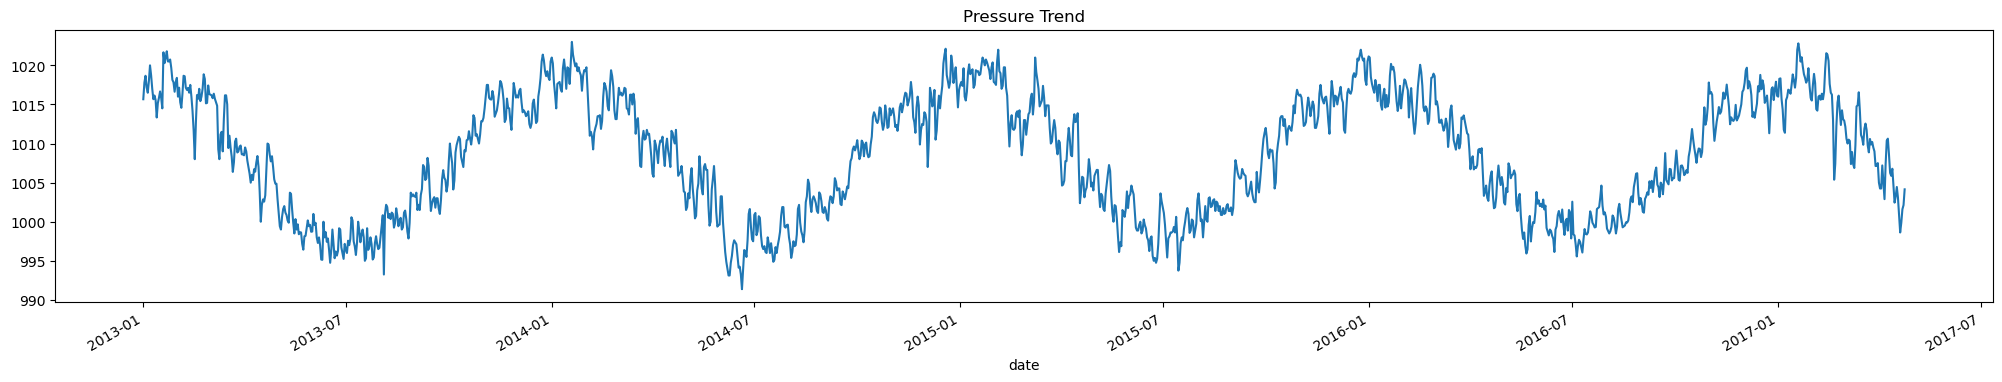

In [6]:
print(df['meanpressure'].max())
print(df['meanpressure'].idxmax())
print(df.loc['2016-03-27'])
print(df.loc['2016-03-28'])
print(df.loc['2016-03-29'])

df.loc[(df['meanpressure'] < 980) | (df['meanpressure'] > 1100), 'meanpressure'] = np.nan
print(df.loc['2016-03-28'])

df['meanpressure'] = df['meanpressure'].interpolate(method='time')
print(df.loc['2016-03-28'])

df['meantemp'].plot(figsize=(25,4), title = "Temperature Trend")
plt.show()

df['humidity'].plot(figsize=(25,4), title="Humidity Trend")
plt.show()

df['meanpressure'].plot(figsize=(25,4), title="Pressure Trend")
plt.show()

In [7]:
df.to_csv('Refined_DaliyDelhiClimateData.csv')

# Z-Score

In [8]:
from scipy.stats import zscore

cols = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']
z_df = df[cols].apply(zscore)

(z_df.head())

meantemp  humidity  wind_speed  meanpressure
date                                                    
2013-01-01 -2.073073  1.417103   -1.530010      0.961267
2013-01-02 -2.427167  1.858940   -0.869152      1.249512
2013-01-03 -2.458944  1.564382   -0.502502      1.366611
2013-01-04 -2.254659  0.641435   -1.256500      1.163939
2013-01-05 -2.617833  1.554564   -0.709482      1.073863

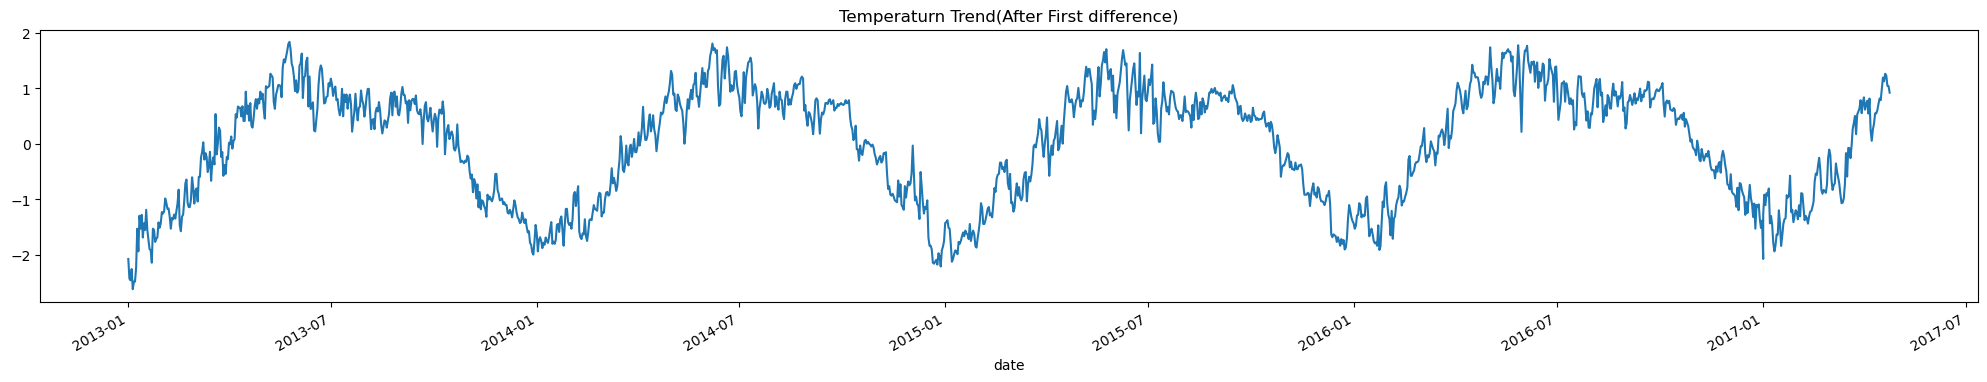

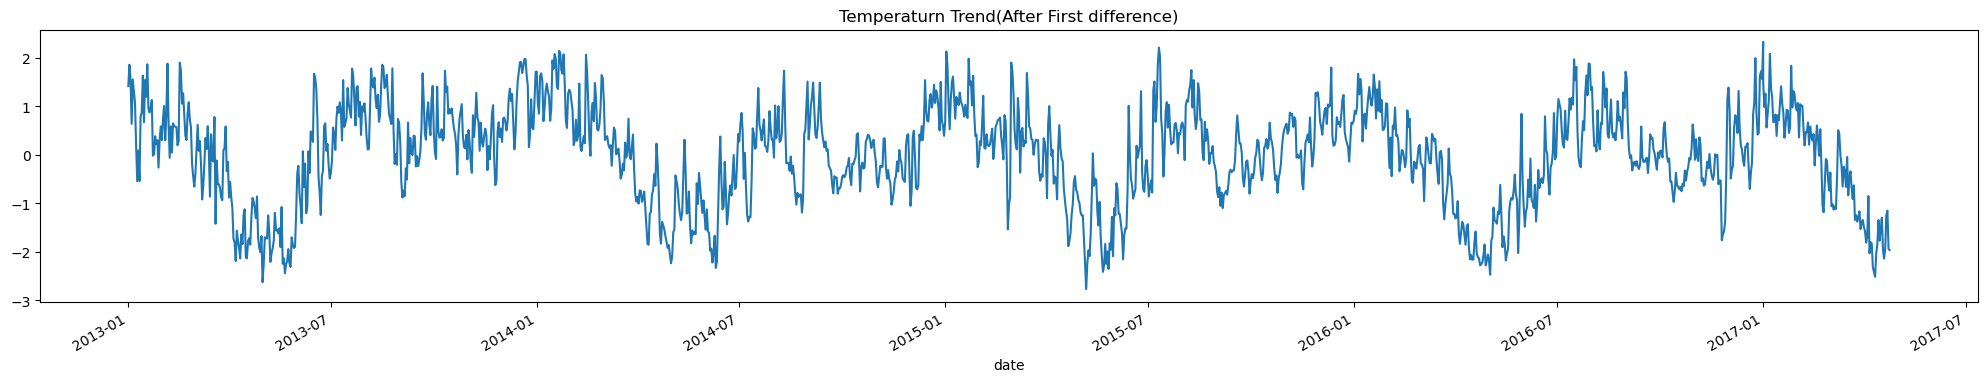

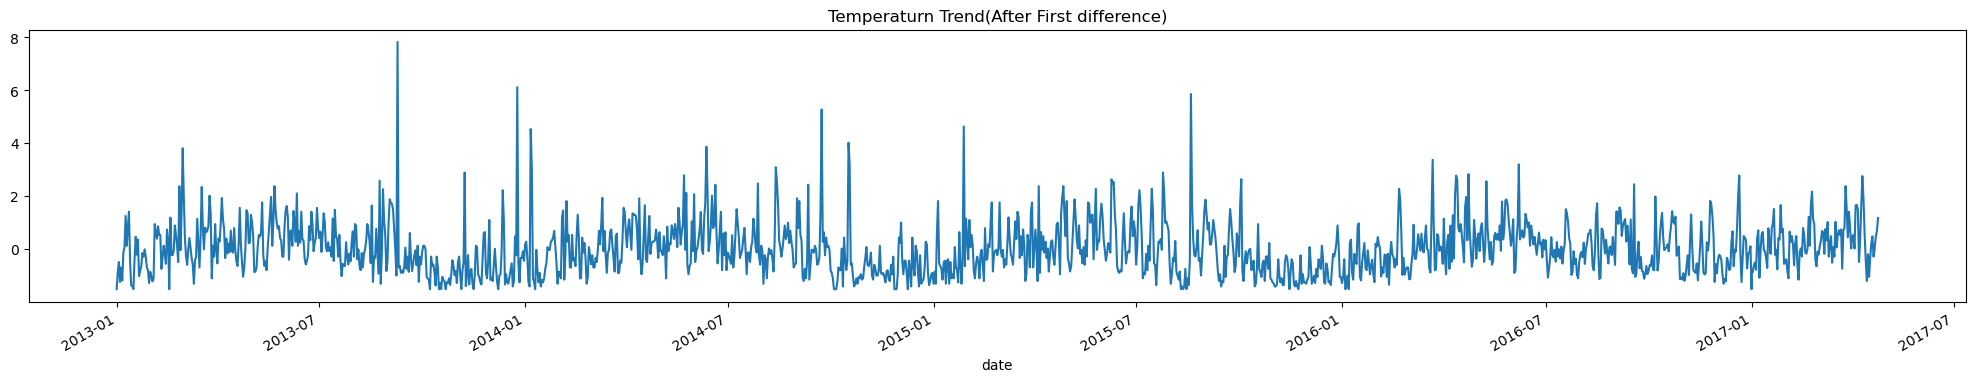

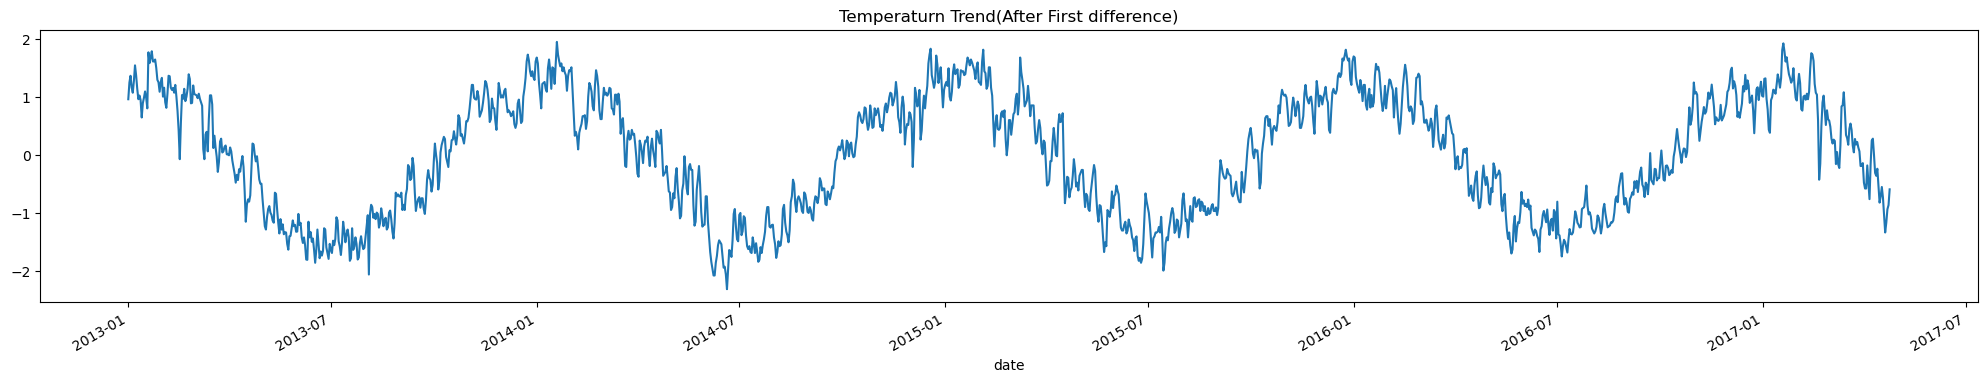

In [9]:
z_df['meantemp'].plot(figsize=(25,4), title = "Temperaturn Trend(After First difference)")
plt.show()
z_df['humidity'].plot(figsize=(25,4), title = "Temperaturn Trend(After First difference)")
plt.show()
z_df['wind_speed'].plot(figsize=(25,4), title = "Temperaturn Trend(After First difference)")
plt.show()
z_df['meanpressure'].plot(figsize=(25,4), title = "Temperaturn Trend(After First difference)")
plt.show()

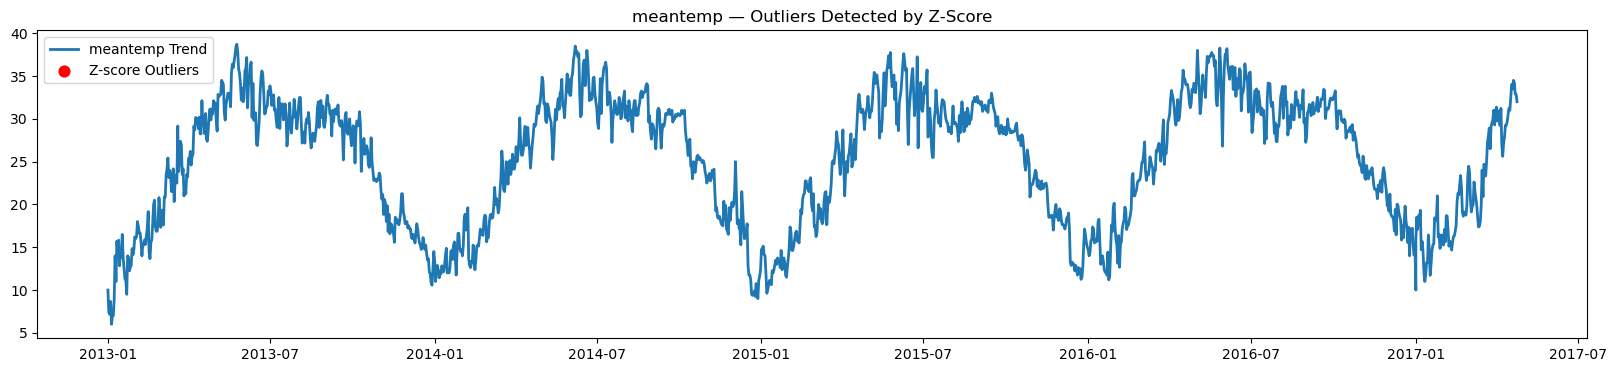

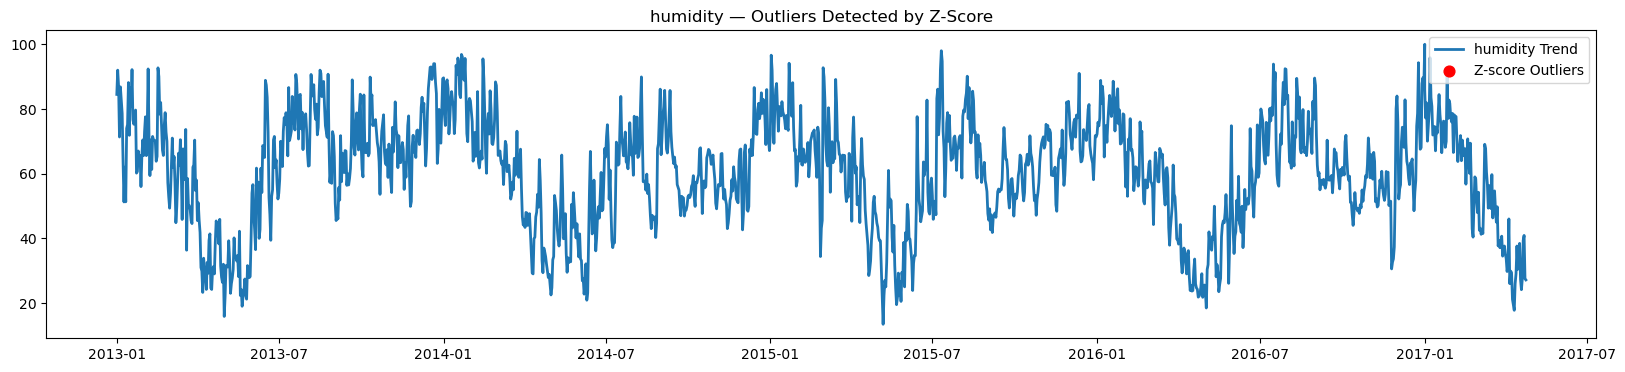

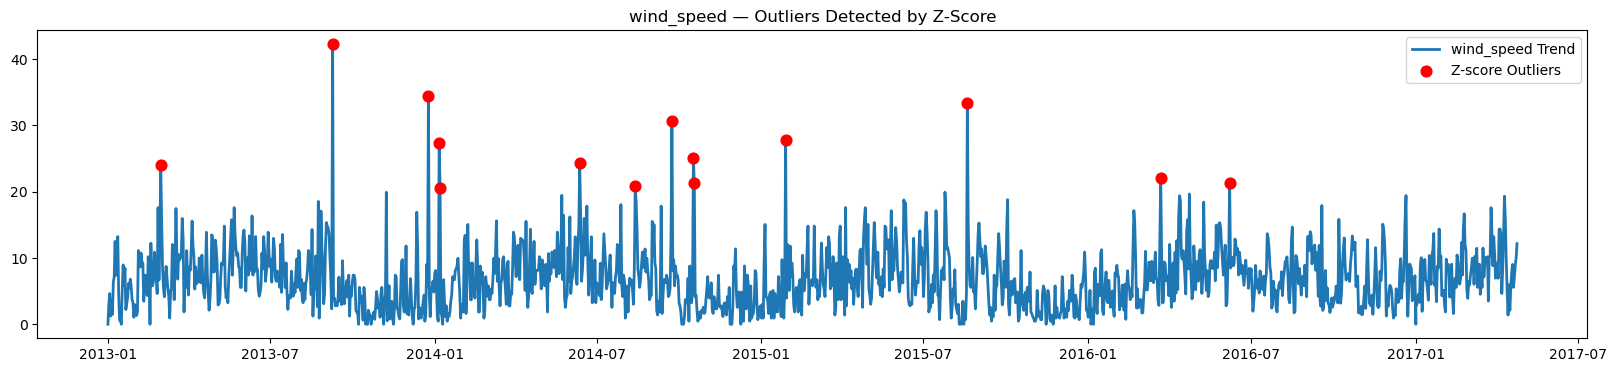

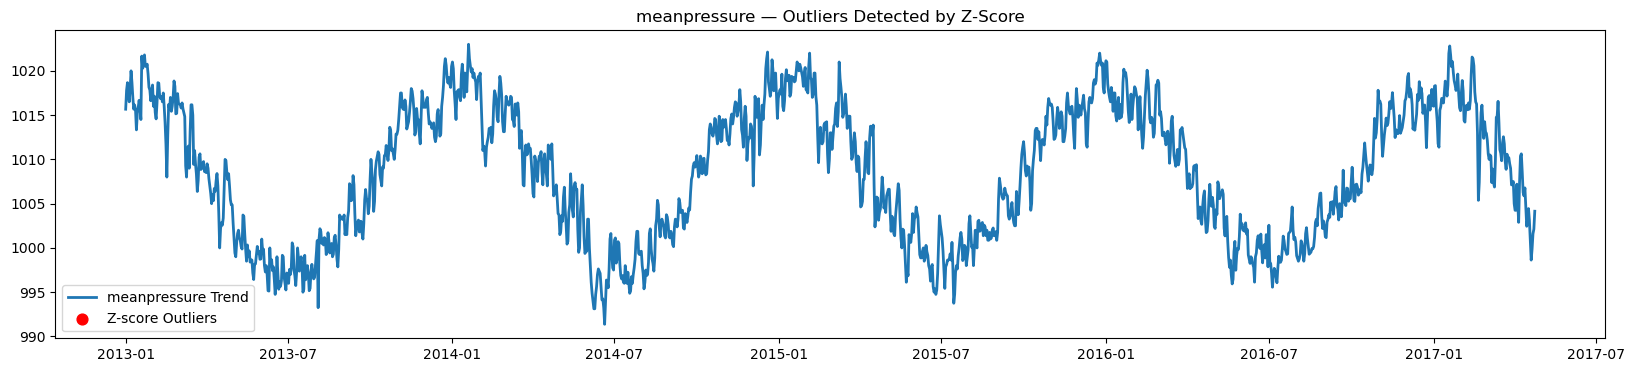

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

df.index = pd.to_datetime(df.index)

numeric_cols = ['meantemp', 'humidity','wind_speed', 'meanpressure']

df_z = df[numeric_cols].apply(zscore)
df_z.index = df.index   # ensure same index type

for col in numeric_cols:
    plt.figure(figsize=(20,4))

    # plot trend
    plt.plot(df.index, df[col], label=f"{col} Trend", linewidth=2)

    # Outlier indices
    outlier_idx = df_z.index[df_z[col].abs() > 3]

    # Final matching indices
    valid_idx = outlier_idx[outlier_idx.isin(df.index)]

    # Extract outlier values
    y_values = df.loc[valid_idx, col]

    # ---- FIX: ensure same lengths ----
    if len(valid_idx) != len(y_values):
        print(f"⚠ Length mismatch found in {col}. Fixing...")
        valid_idx = y_values.index

    # plot outliers
    plt.scatter(valid_idx, y_values,
                color='red', s=60, label="Z-score Outliers", zorder=5)

    plt.title(f"{col} — Outliers Detected by Z-Score")
    plt.legend()
    plt.show()


above the outliers are the normal natural outlier (like storm and fast wind)

# IQR Check

In [11]:
# numeric_cols = ['meantemp','humidity','wind_speed','meanpressure']

# outlier_rows = pd.DataFrame()
# iqr_limits = {}
# # Loop through every numeric column
# for col in numeric_cols:
#     Q1 = df[col].quantile(0.25)
#     Q3 = df[col].quantile(0.75)
#     IQR = Q3 - Q1
    
#     lower = Q1 - 1.5 * IQR
#     upper = Q3 + 1.5 * IQR

#     iqr_limits[col] = {"lower": lower, "upper": upper}
    
#     # Get outliers for this column
#     col_outliers = df[(df[col] < lower) | (df[col] > upper)]
    
#     # Combine all outlier rows
#     outlier_rows = pd.concat([outlier_rows, col_outliers])
    
# # Drop duplicate rows where multiple columns were outliers
# outlier_rows = outlier_rows.drop_duplicates()
# print(outlier_rows)
# print(outlier_rows.shape)

In [12]:
# numeric_cols = ['meantemp','humidity','wind_speed','meanpressure']

# for col in numeric_cols:
#     plt.figure(figsize=(25,4))
    
#     df[col].plot(title=f"{col} Trend")
    
#     plt.scatter(outlier_rows.index, outlier_rows[col], color='red', label='Outliers', zorder=5)
    
#     plt.legend()
#     plt.show()

# Level shift

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

numeric_cols = ['meantemp','humidity','wind_speed','meanpressure']
window = 5 

level_shifts = pd.DataFrame() 

for col in numeric_cols:
    
    rolling_mean = df[col].rolling(window=window).mean()
       
    diff = rolling_mean.diff()
    
    threshold = 0.1 * df[col].std()  

    shift_points = df[abs(diff) > threshold]
    
    level_shifts = pd.concat([level_shifts, shift_points])
    
level_shifts = level_shifts.drop_duplicates()
print(level_shifts)


             meantemp   humidity  wind_speed  meanpressure
date                                                      
2013-01-09  14.000000  51.250000   12.500000   1017.000000
2013-01-10  11.000000  62.000000    7.400000   1015.666667
2013-01-11  15.714286  51.285714   10.571429   1016.142857
2013-01-12  14.000000  74.000000   13.228571   1015.571429
2013-01-13  15.833333  75.166667    4.633333   1013.333333
...               ...        ...         ...           ...
2016-12-11  20.041667  69.583333    4.716667   1013.291667
2017-02-14  16.875000  65.500000    6.962500   1021.375000
2017-02-22  19.125000  57.125000    7.412500   1012.250000
2017-04-02  29.750000  33.750000    9.262500   1004.250000
2017-04-20  34.500000  27.500000    5.562500    998.625000

[1359 rows x 4 columns]


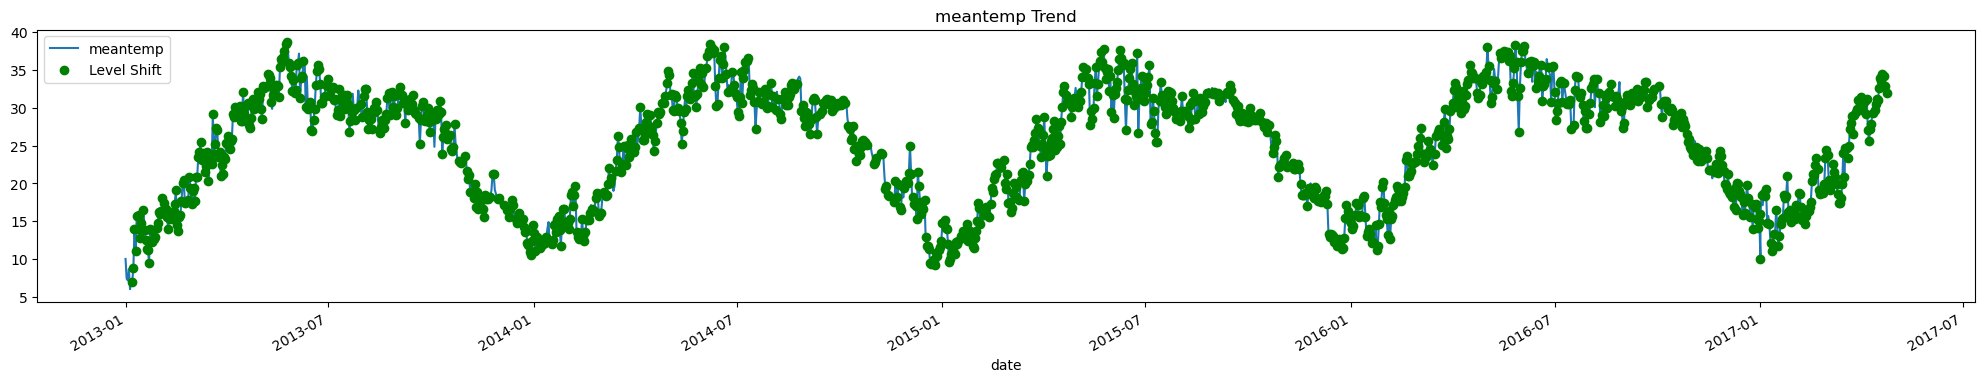

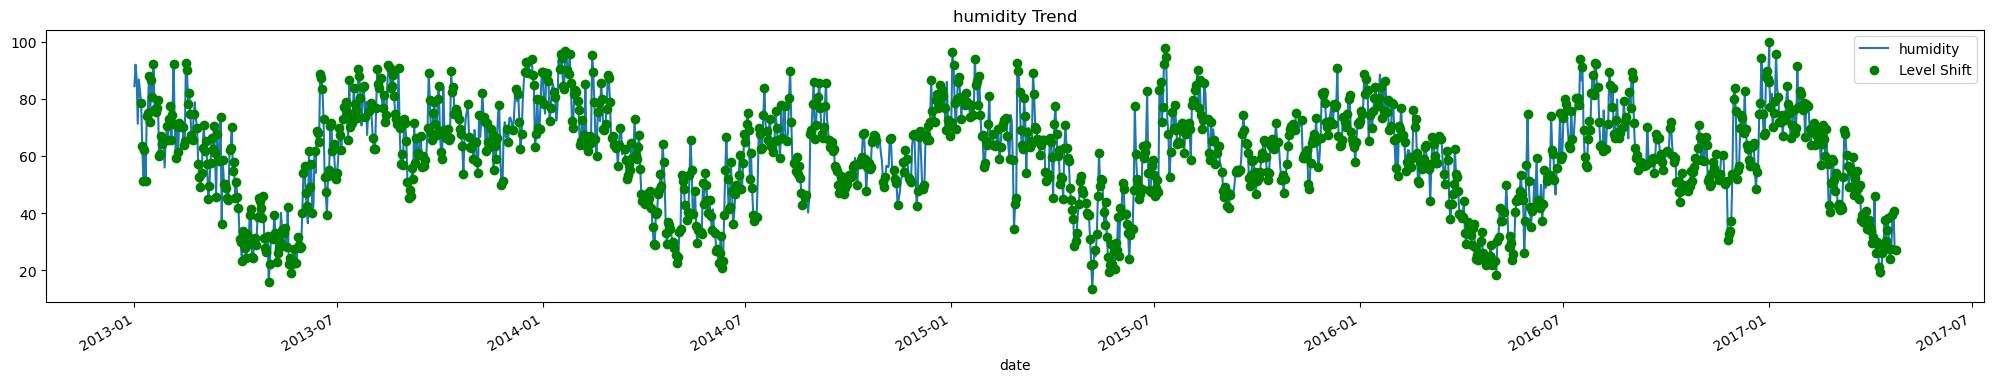

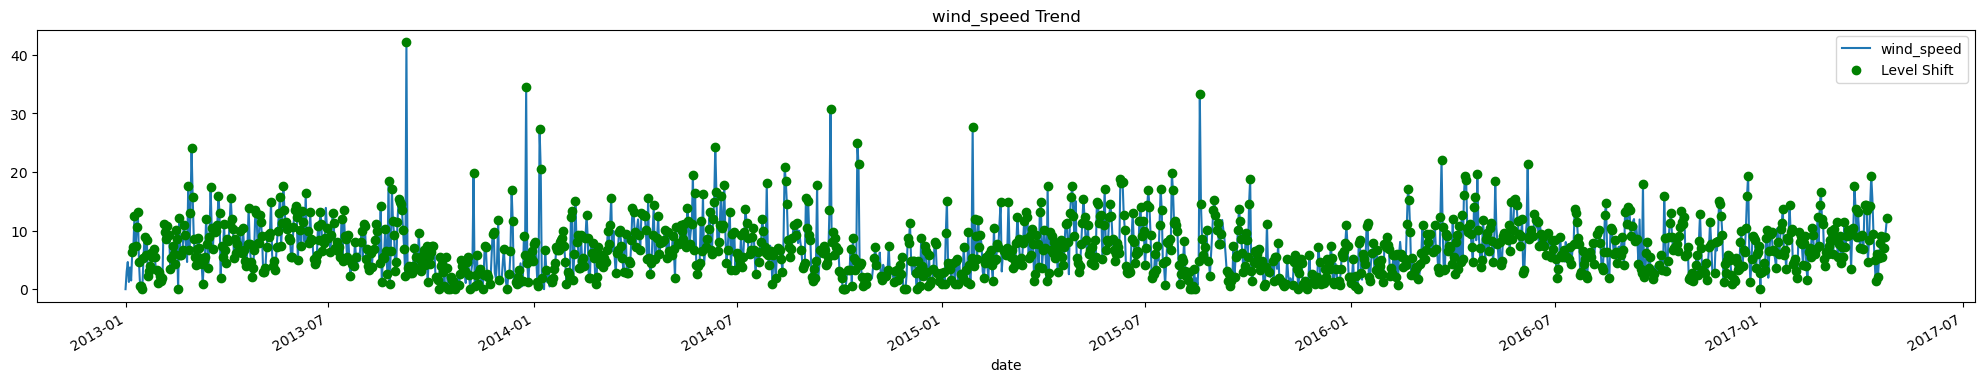

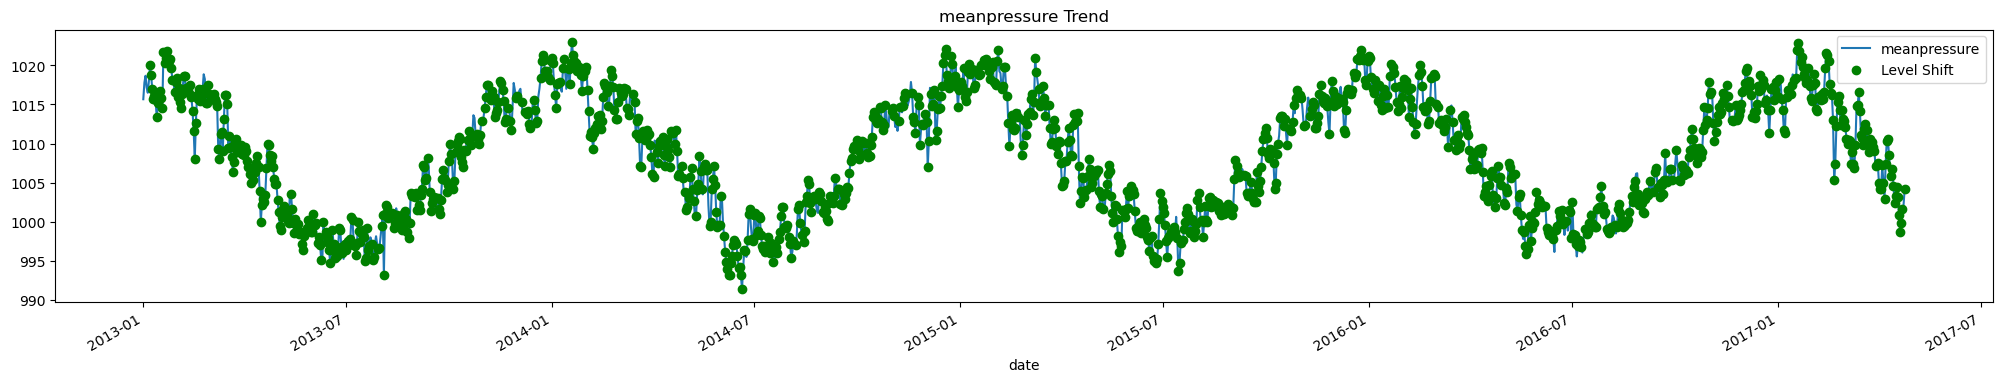

In [14]:
for col in numeric_cols:
    plt.figure(figsize=(25,4))
    
    # Plot main data
    df[col].plot(title=f"{col} Trend")
    
    # Plot level shifts in green
    plt.scatter(level_shifts.index, level_shifts[col], color='green', label='Level Shift', zorder=5)

    
    plt.legend()
    plt.show()

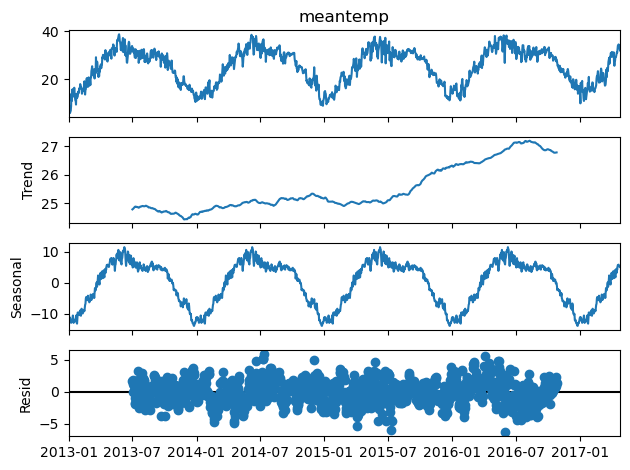

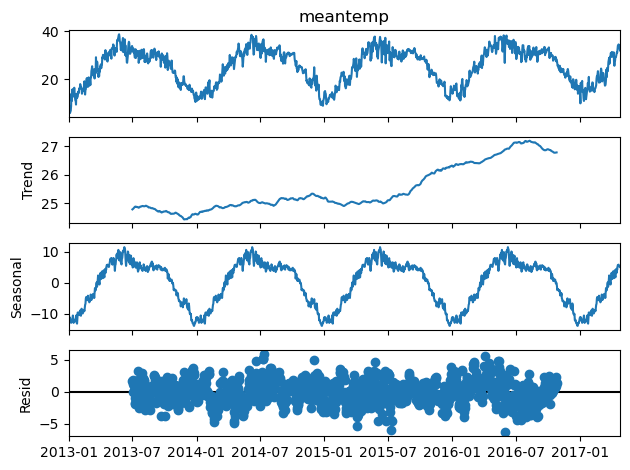

In [15]:

decomp = seasonal_decompose(df['meantemp'], model="additive", period=365)
decomp.plot()

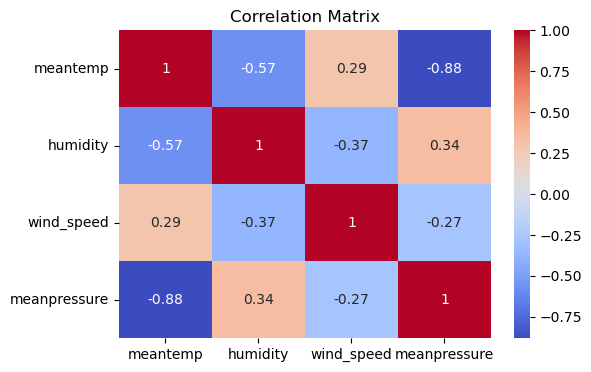

In [16]:

plt.figure(figsize=(6,4))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [17]:
df['temp_lag1'] = df['meantemp'].shift(1)
df['temp_lag7'] = df['meantemp'].shift(7)
df['temp_rolling7'] = df['meantemp'].rolling(7).mean()
df['temp_rolling30'] = df['meantemp'].rolling(30).mean()

In [18]:
df.head(30)

meantemp   humidity  wind_speed  meanpressure  temp_lag1  \
date                                                                    
2013-01-01  10.000000  84.500000    0.000000   1015.666667        NaN   
2013-01-02   7.400000  92.000000    2.980000   1017.800000  10.000000   
2013-01-03   7.166667  87.000000    4.633333   1018.666667   7.400000   
2013-01-04   8.666667  71.333333    1.233333   1017.166667   7.166667   
2013-01-05   6.000000  86.833333    3.700000   1016.500000   8.666667   
2013-01-06   7.000000  82.800000    1.480000   1018.000000   6.000000   
2013-01-07   7.000000  78.600000    6.300000   1020.000000   7.000000   
2013-01-08   8.857143  63.714286    7.142857   1018.714286   7.000000   
2013-01-09  14.000000  51.250000   12.500000   1017.000000   8.857143   
2013-01-10  11.000000  62.000000    7.400000   1015.666667  14.000000   
2013-01-11  15.714286  51.285714   10.571429   1016.142857  11.000000   
2013-01-12  14.000000  74.000000   13.228571   1015.571429  15.714286   
2013-01-13  15.833333  75.166667    4.633333   1013.333333  14.000000   
2013-01-14  12.833333  88.166667    0.616667   1015.166667  15.833333   
2013-01-15  14.714286  71.857143    0.528571   1015.857143  12.833333   
2013-01-16  13.833333  86.666667    0.000000   1016.666667  14.714286   
2013-01-17  16.500000  80.833333    5.250000   1015.833333  13.833333   
2013-01-18  13.833333  92.166667    8.950000   1014.500000  16.500000   
2013-01-19  12.500000  76.666667    5.883333   1021.666667  13.833333   
2013-01-20  11.285714  75.285714    8.471429   1020.285714  12.500000   
2013-01-21  11.200000  77.000000    2.220000   1021.000000  11.285714   
2013-01-22   9.500000  79.666667    3.083333   1021.800000  11.200000   
2013-01-23  14.000000  60.166667    4.016667   1020.500000   9.500000   
2013-01-24  13.833333  60.666667    6.166667   1020.500000  14.000000   
2013-01-25  12.250000  67.000000    5.550000   1020.750000  13.833333   
2013-01-26  12.666667  64.166667    6.800000   1019.666667  12.250000   
2013-01-27  12.857143  65.571429    5.557143   1018.142857  12.666667   
2013-01-28  14.833333  56.000000    3.700000   1017.833333  12.857143   
2013-01-29  14.125000  65.500000    3.237500   1016.625000  14.833333   
2013-01-30  14.714286  70.428571    1.057143   1017.857143  14.125000   

            temp_lag7  temp_rolling7  temp_rolling30  
date                                                  
2013-01-01        NaN            NaN             NaN  
2013-01-02        NaN            NaN             NaN  
2013-01-03        NaN            NaN             NaN  
2013-01-04        NaN            NaN             NaN  
2013-01-05        NaN            NaN             NaN  
2013-01-06        NaN            NaN             NaN  
2013-01-07        NaN       7.604762             NaN  
2013-01-08  10.000000       7.441497             NaN  
2013-01-09   7.400000       8.384354             NaN  
2013-01-10   7.166667       8.931973             NaN  
2013-01-11   8.666667       9.938776             NaN  
2013-01-12   6.000000      11.081633             NaN  
2013-01-13   7.000000      12.343537             NaN  
2013-01-14   7.000000      13.176871             NaN  
2013-01-15   8.857143      14.013605             NaN  
2013-01-16  14.000000      13.989796             NaN  
2013-01-17  11.000000      14.775510             NaN  
2013-01-18  15.714286      14.506803             NaN  
2013-01-19  14.000000      14.292517             NaN  
2013-01-20  15.833333      13.642857             NaN  
2013-01-21  12.833333      13.409524             NaN  
2013-01-22  14.714286      12.664626             NaN  
2013-01-23  13.833333      12.688435             NaN  
2013-01-24  16.500000      12.307483             NaN  
2013-01-25  13.833333      12.081293             NaN  
2013-01-26  12.500000      12.105102             NaN  
2013-01-27  11.285714      12.329592             NaN  
2013-01-28  11.200000      12.848639             NaN  
2013-01-29   9.500000     

## ADF Test

In [19]:
result = adfuller(df['meantemp'].dropna())

print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -2.37918994845209
p-value: 0.14769623489792427


In [20]:
result = adfuller(df['temp_rolling7'].dropna())

print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -3.0423654606798887
p-value: 0.03112297504862026


## KPSS Test

In [21]:
# result_kpss = kpss(df['meantemp'].dropna(), regression='c')

# print('KPSS Statistic:', result_kpss[0])
# print('p-value:', result_kpss[1])

In [22]:
# result_kpss = kpss(df['temp_rolling7'].dropna(), regression='c')

# print('KPSS Statistic:', result_kpss[0])
# print('p-value:', result_kpss[1])

## Detrend the data

In [23]:
df['meantemp_detrended'] = detrend(df['meantemp'])
print(adfuller(df['meantemp'].dropna()))


(np.float64(-2.37918994845209), np.float64(0.14769623489792427), 10, 1565, {'1%': np.float64(-3.4345353407734733), '5%': np.float64(-2.86338857621683), '10%': np.float64(-2.567754150088293)}, np.float64(5876.969927388109))


it failed make date stationary

## First Difference

In [24]:
df['meantemp_diff'] = df['meantemp'].diff()
adf_result = adfuller(df['meantemp_diff'].dropna())
print(adf_result)

(np.float64(-16.908987764987316), np.float64(1.0140938123173638e-29), 9, 1565, {'1%': np.float64(-3.4345353407734733), '5%': np.float64(-2.86338857621683), '10%': np.float64(-2.567754150088293)}, np.float64(5877.856608280856))


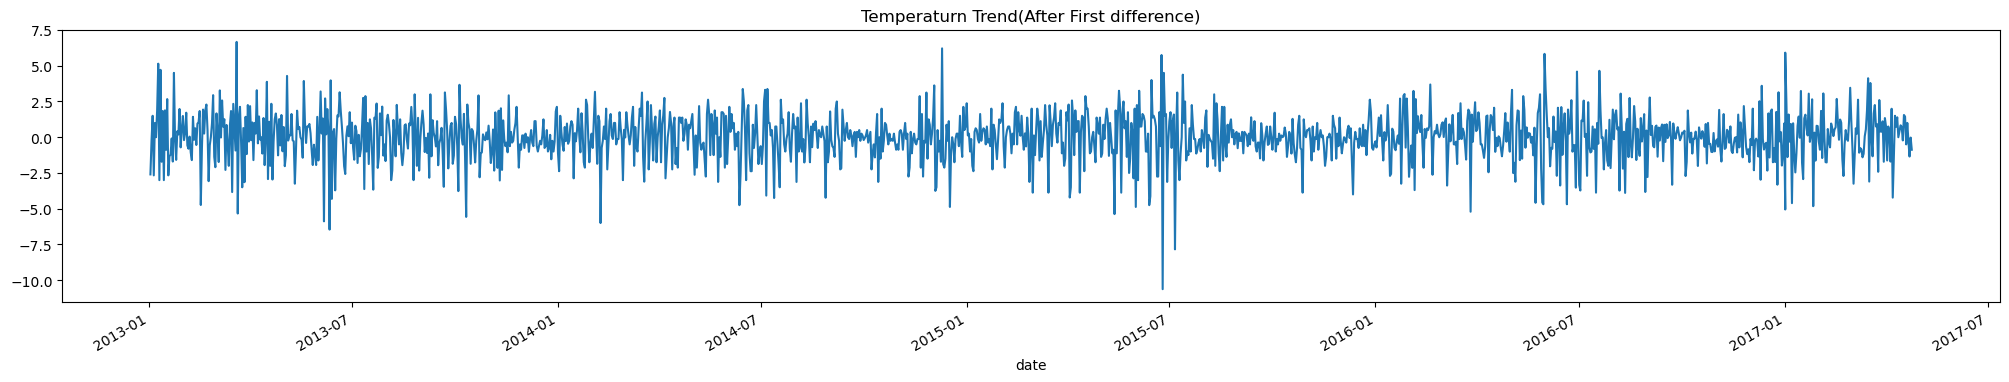

In [25]:
df['meantemp_diff'].plot(figsize=(25,4), title = "Temperaturn Trend(After First difference)")
plt.show()

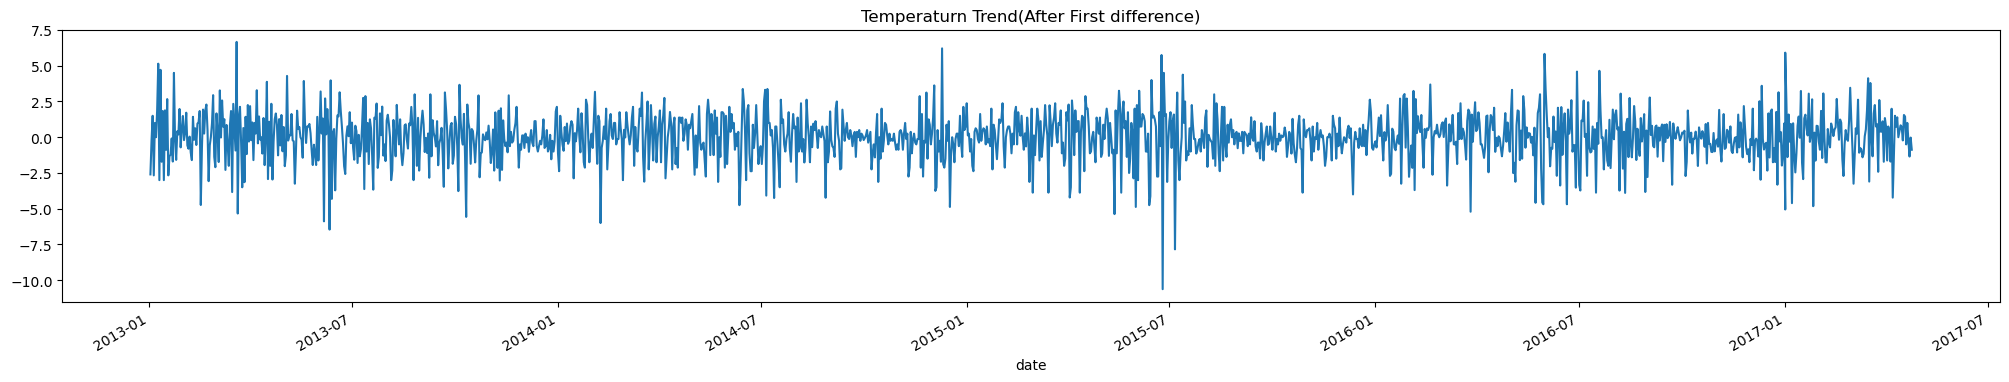

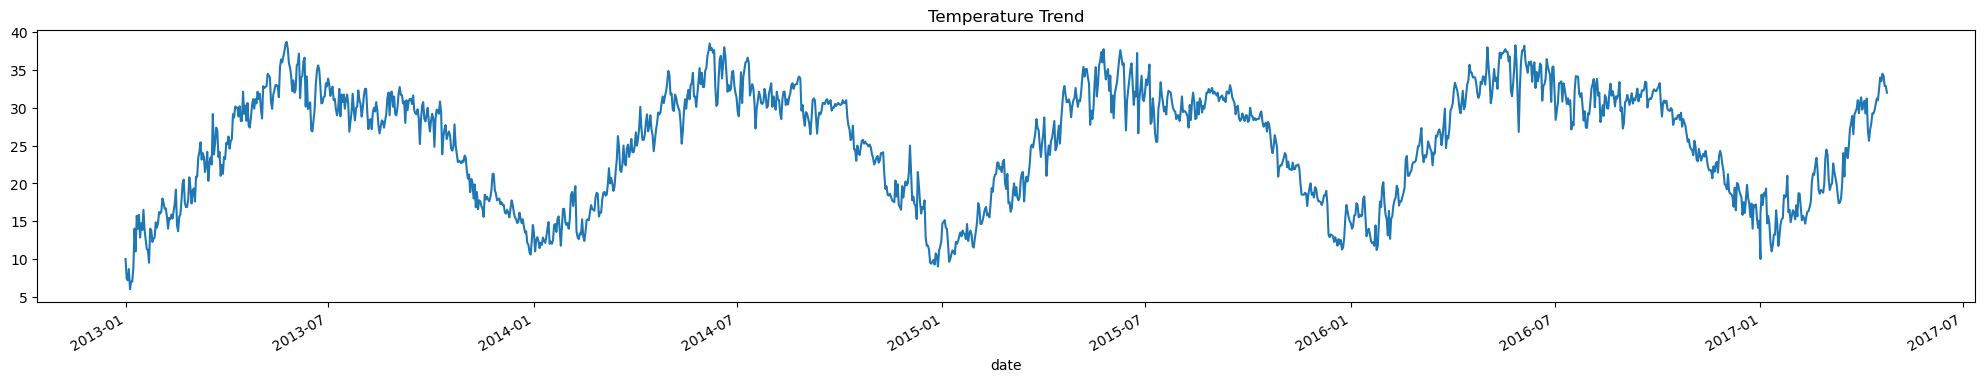

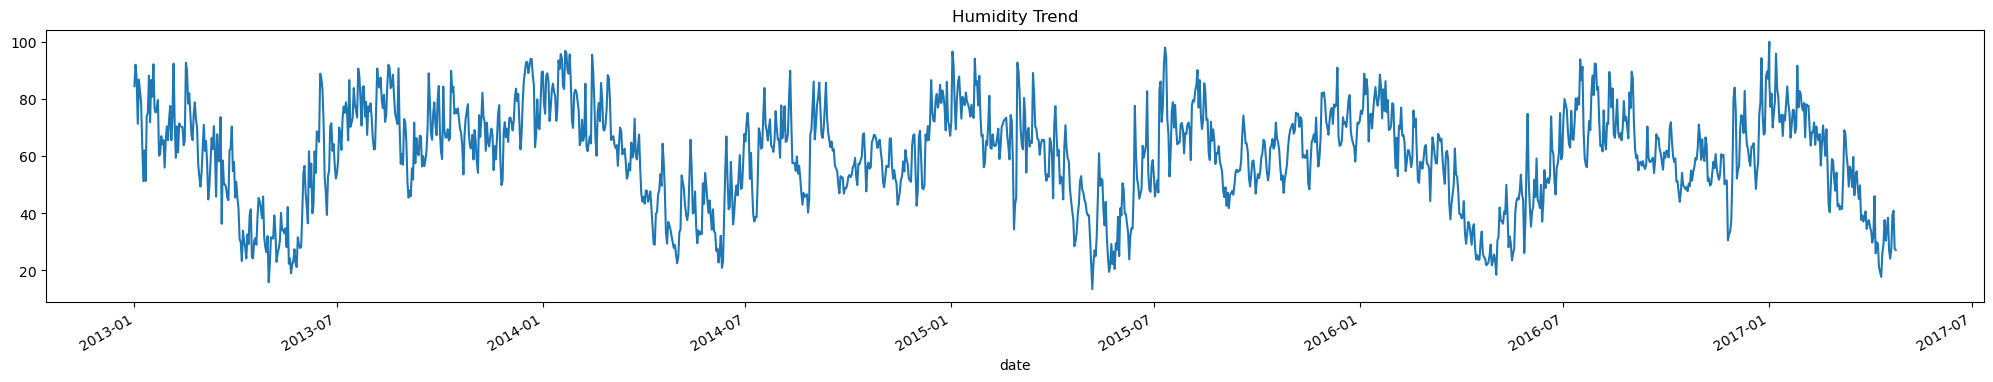

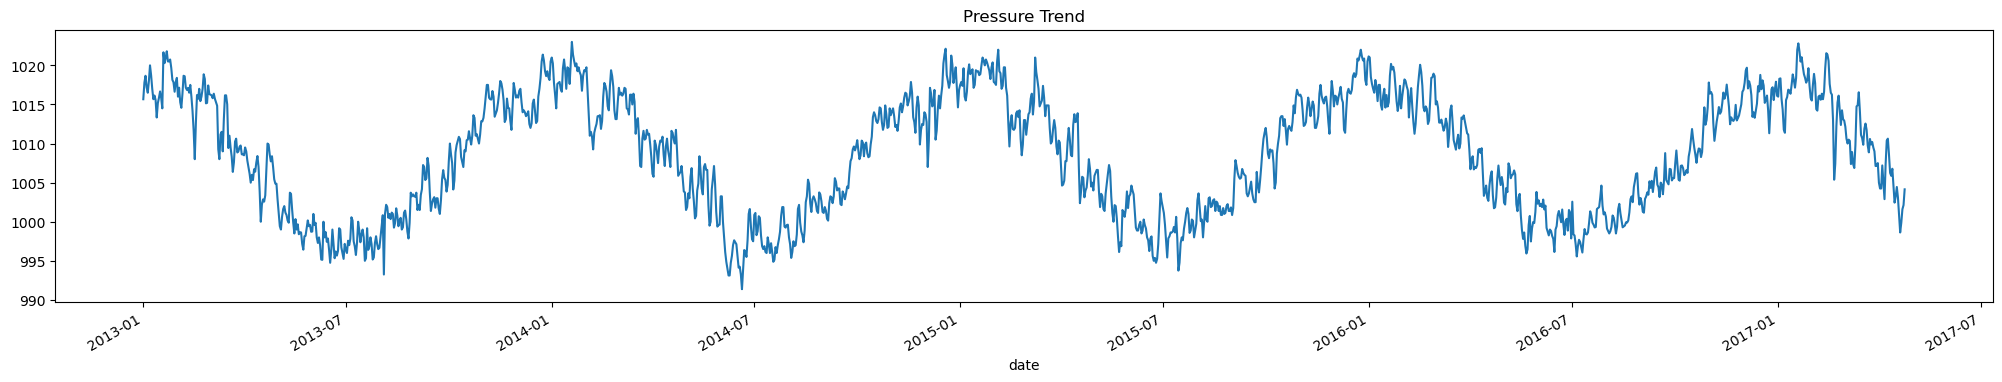

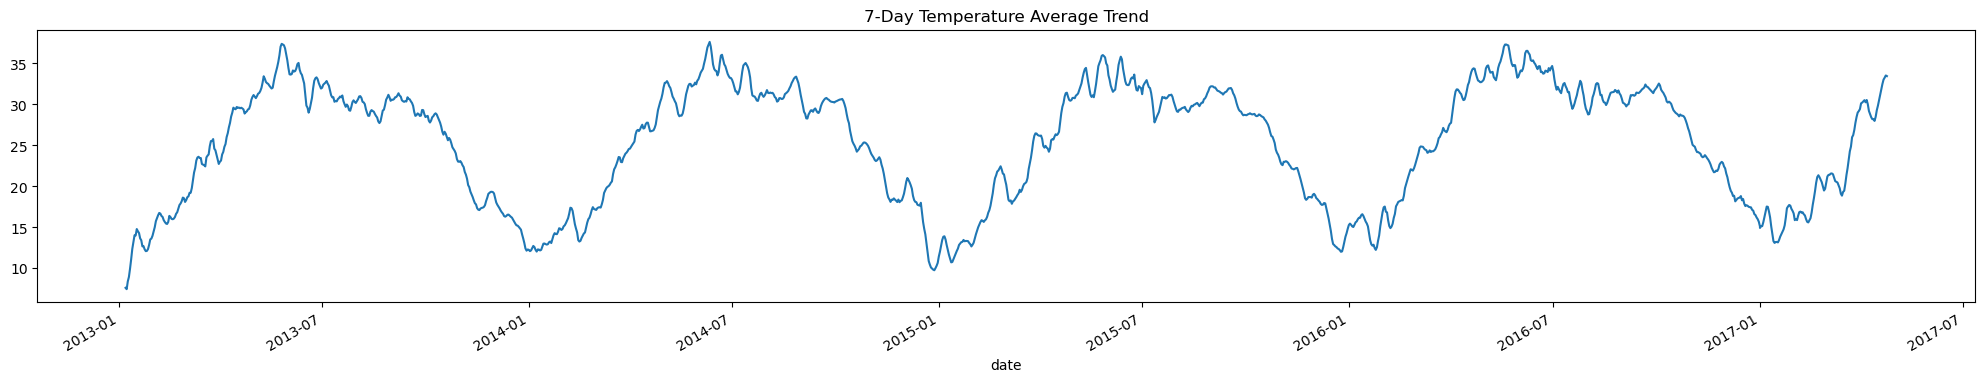

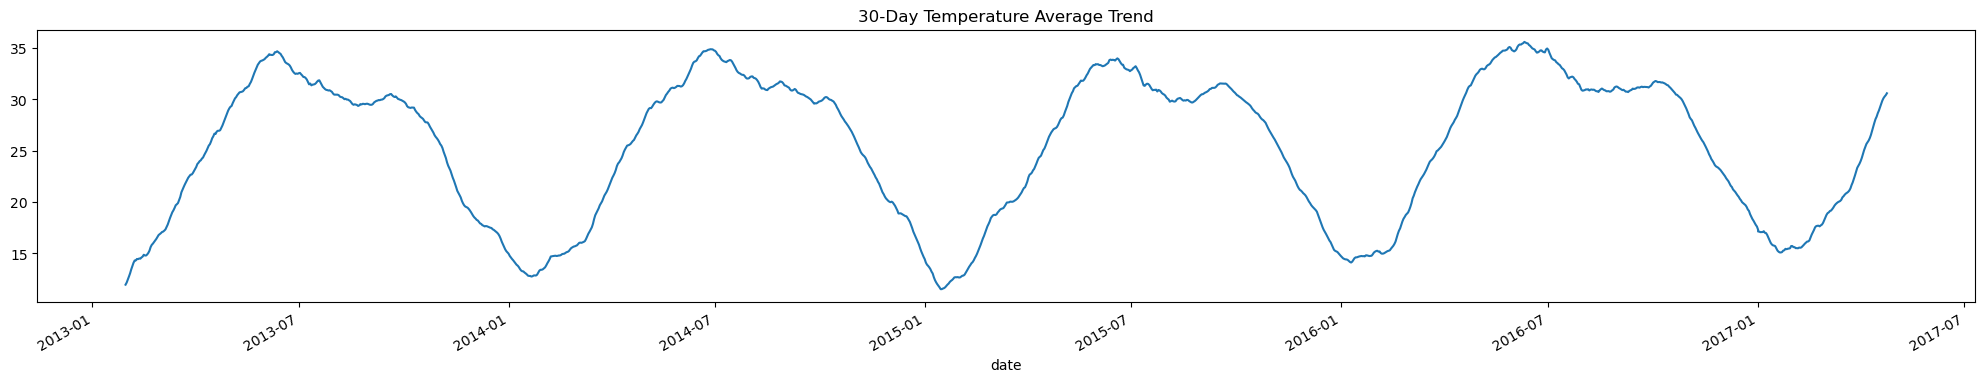

In [26]:
df['meantemp_diff'].plot(figsize=(25,4), title = "Temperaturn Trend(After First difference)")
plt.show()

df['meantemp'].plot(figsize=(25,4), title = "Temperature Trend")
plt.show()

df['humidity'].plot(figsize=(25,4), title="Humidity Trend")
plt.show()

df['meanpressure'].plot(figsize=(25,4), title="Pressure Trend")
plt.show()

df['temp_rolling7'].plot(figsize=(25,4), title="7-Day Temperature Average Trend")
plt.show()

df['temp_rolling30'].plot(figsize=(25,4), title="30-Day Temperature Average Trend")
plt.show()

<Figure size 1200x500 with 0 Axes>

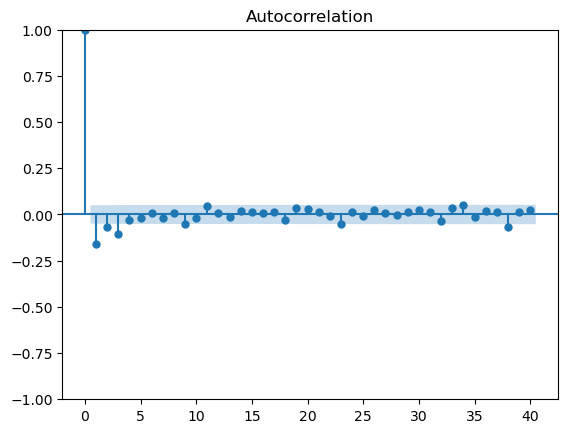

<Figure size 1200x500 with 0 Axes>

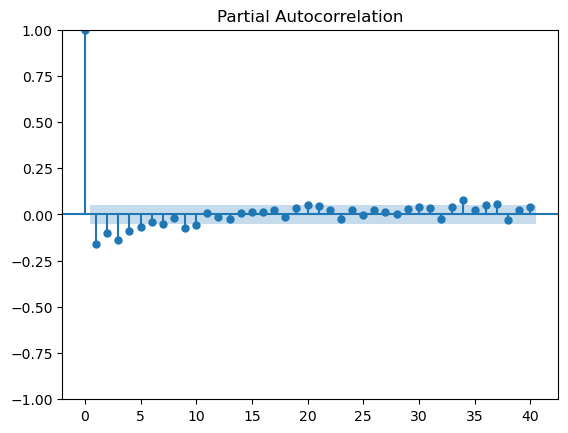

In [27]:
plt.figure(figsize=(12,5))
plot_acf(df['meantemp_diff'].dropna(), lags=40)
plt.show()

plt.figure(figsize=(12,5))
plot_pacf(df['meantemp_diff'].dropna(), lags=40)
plt.show()

## ARIMA model

In [28]:
model = ARIMA(df['meantemp'], order=(1,1,1))
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:               meantemp   No. Observations:                 1576
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2993.895
Date:                Tue, 16 Dec 2025   AIC                           5993.790
Time:                        16:22:29   BIC                           6009.876
Sample:                             0   HQIC                          5999.768
                               - 1576                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5854      0.045     13.053      0.000       0.498       0.673
ma.L1         -0.8066      0.035    -22.898      0.000      -0.876      -0.738
sigma2         2.6216      0.071     36.762      0.0

C:\Users\Kartikey Soni\.conda\envs\SIP_Project_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Kartikey Soni\.conda\envs\SIP_Project_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Kartikey Soni\.conda\envs\SIP_Project_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [29]:
model_110 = ARIMA(df['meantemp'], order=(1,1,0)).fit()
print(model_110.aic)

C:\Users\Kartikey Soni\.conda\envs\SIP_Project_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Kartikey Soni\.conda\envs\SIP_Project_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Kartikey Soni\.conda\envs\SIP_Project_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


6064.370448718346


In [30]:
model_011 = ARIMA(df['meantemp'], order=(0,1,1)).fit()
print(model_011.aic)

6052.7651483874


C:\Users\Kartikey Soni\.conda\envs\SIP_Project_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Kartikey Soni\.conda\envs\SIP_Project_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Kartikey Soni\.conda\envs\SIP_Project_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [31]:
df.head()

meantemp   humidity  wind_speed  meanpressure  temp_lag1  \
date                                                                    
2013-01-01  10.000000  84.500000    0.000000   1015.666667        NaN   
2013-01-02   7.400000  92.000000    2.980000   1017.800000  10.000000   
2013-01-03   7.166667  87.000000    4.633333   1018.666667   7.400000   
2013-01-04   8.666667  71.333333    1.233333   1017.166667   7.166667   
2013-01-05   6.000000  86.833333    3.700000   1016.500000   8.666667   

            temp_lag7  temp_rolling7  temp_rolling30  meantemp_detrended  \
date                                                                       
2013-01-01        NaN            NaN             NaN          -14.504035   
2013-01-02        NaN            NaN             NaN          -17.104947   
2013-01-03        NaN            NaN             NaN          -17.339192   
2013-01-04        NaN            NaN             NaN          -15.840103   
2013-01-05        NaN            NaN             NaN          -18.507682   

            meantemp_diff  
date                       
2013-01-01            NaN  
2013-01-02      -2.600000  
2013-01-03      -0.233333  
2013-01-04       1.500000  
2013-01-05      -2.666667

## Train-Test Split

In [32]:
df.index = pd.to_datetime(df.index)

# remove duplicate dates, keep first occurrence
df = df[~df.index.duplicated(keep='first')]

df = df.asfreq('D')

In [33]:
train = df.iloc[:-30]
test  = df.iloc[-30:]

In [34]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train['meantemp'], order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())
forecast = model_fit.forecast(steps=30)

                               SARIMAX Results                                
Dep. Variable:               meantemp   No. Observations:                 1545
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2942.645
Date:                Tue, 16 Dec 2025   AIC                           5891.290
Time:                        16:22:29   BIC                           5907.316
Sample:                    01-01-2013   HQIC                          5897.251
                         - 03-25-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5828      0.045     13.019      0.000       0.495       0.671
ma.L1         -0.8103      0.035    -23.204      0.000      -0.879      -0.742
sigma2         2.6477      0.072     36.746      0.0

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_true = test['meantemp']
y_pred = forecast

mae  = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2   = r2_score(y_true, y_pred)

print("MAE :", mae)
print("RMSE:", rmse)
print("R²  :", r2)


MAE : 4.7559933789811755
RMSE: 5.208899316174601
R²  : -4.955092694823026


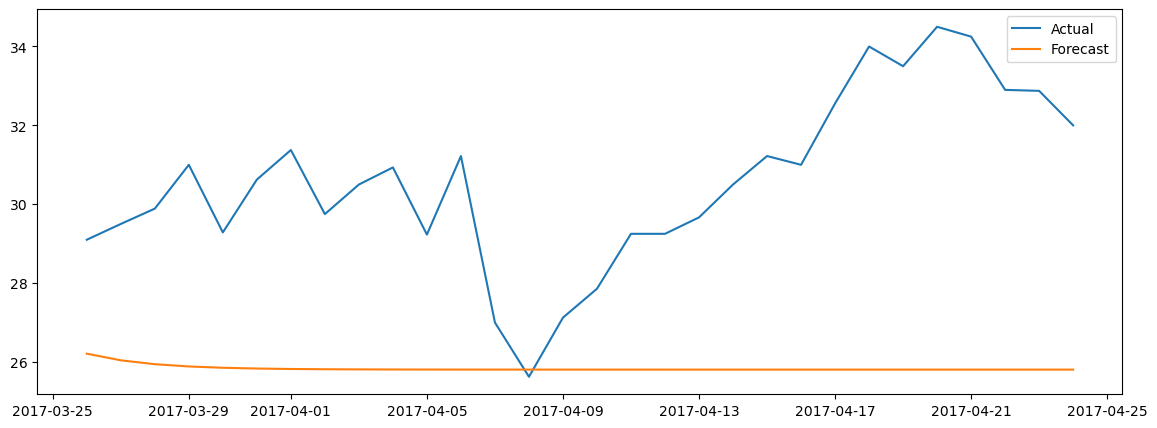

In [36]:
plt.figure(figsize=(14,5))
plt.plot(test.index, test['meantemp'], label='Actual')
plt.plot(test.index, forecast, label='Forecast')
plt.legend()
plt.show()


<Axes: xlabel='date'>

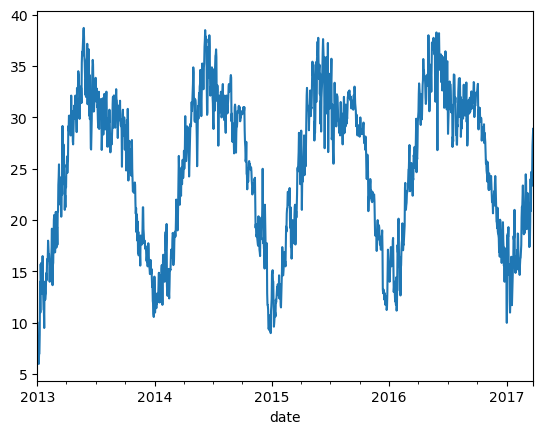

In [37]:
train['meantemp'].plot()

# SARIMA

In [38]:
# df.index = pd.to_datetime(df.index)
# df = df[~df.index.duplicated()]
# df = df.asfreq('D')

In [39]:
# train = df['meantemp'][:-365]
# test  = df['meantemp'][-365:]


In [40]:
# from statsmodels.tsa.statespace.sarimax import SARIMAX

# model = SARIMAX(
#     train,
#     order=(1,1,1),
#     seasonal_order=(1,1,1,365),
#     enforce_stationarity=False,
#     enforce_invertibility=False
# )

# sarima_fit = model.fit()
# forecast = sarima_fit.forecast(steps=len(test))

In [41]:
# plt.figure(figsize=(14,6))
# plt.plot(train.index, train, label='Train')
# plt.plot(test.index, test, label='Actual')
# plt.plot(test.index, forecast, label='SARIMA Forecast')
# plt.legend()
# plt.show()

# Change the model

In [42]:
df2 = df.copy()
df2.dropna(inplace=True)

In [43]:
# df2['dayofyear'] = df2.index.dayofyear
# df2['sin_year'] = np.sin(2 * np.pi * df2['dayofyear'] / 365)
# df2['cos_year'] = np.cos(2 * np.pi * df2['dayofyear'] / 365)

# df2['temp_lag1'] = df2['meantemp'].shift(1)
# df2['temp_lag7'] = df2['meantemp'].shift(7)
# df2['temp_roll7'] = df2['meantemp'].rolling(7).mean()


In [44]:
# df2

In [45]:
# train = df2.iloc[:-30]
# test = df2.iloc[-30:]


In [46]:
# from statsmodels.tsa.statespace.sarimax import SARIMAX

# model = SARIMAX(
#     train['meantemp'],
#     exog=train[['sin_year','cos_year']],
#     order=(2,1,2),
#     enforce_stationarity=False,
#     enforce_invertibility=False
# )

# fit = model.fit(disp=False)


In [47]:
# forecast = fit.forecast(
#     steps=len(test),
#     exog=test[['sin_year','cos_year']]
# )

In [48]:
# plt.figure(figsize=(14,6))
# plt.plot(train.index, train['meantemp'], label='Train')
# plt.plot(test.index, test['meantemp'], label='Actual')
# plt.plot(test.index, forecast, label='Forecast')
# plt.legend()
# plt.show()


In [49]:
# from sklearn.metrics import mean_absolute_error, mean_squared_error
# import numpy as np

# mae = mean_absolute_error(test['meantemp'], forecast)
# rmse = np.sqrt(mean_squared_error(test['meantemp'], forecast))

# print("MAE:", mae)
# print("RMSE:", rmse)


In [50]:
# sarima_fit = model.fit(disp=False)

In [51]:
# # Predict next 7 days
# future_steps = 7
# future_forecast = sarima_fit.forecast(steps=future_steps)

# print(future_forecast)


In [52]:
# this also not working correctly

# exog_cols = ['humidity', 'meanpressure', 'wind_speed']

# train = df.iloc[:-30]
# test  = df.iloc[-30:]

# y_train = train['meantemp']
# y_test  = test['meantemp']

# X_train = train[exog_cols]
# X_test  = test[exog_cols]

# from statsmodels.tsa.statespace.sarimax import SARIMAX

# model = SARIMAX(
#     y_train,
#     exog=X_train,
#     order=(2,1,2),
#     seasonal_order=(1,1,1,365)
# )

# sarima_fit = model.fit(disp=False)

# forecast = sarima_fit.forecast(
#     steps=len(test),
#     exog=X_test
# )

# plt.figure(figsize=(14,6))
# plt.plot(train.index, y_train, label='Train')
# plt.plot(test.index, y_test, label='Actual')
# plt.plot(test.index, forecast, label='Forecast')
# plt.legend()
# plt.show()

# C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
# warn('Non-invertible starting seasonal moving average'

# SARIMAX WITH NOT SEASONALITY(0,0,0,0)

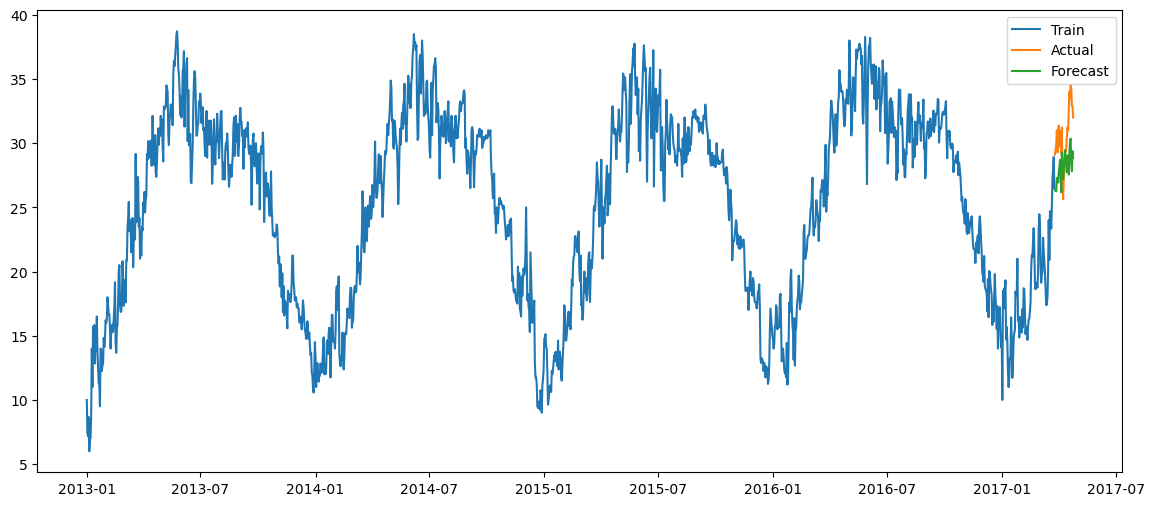

MAE : 2.7816953790024184
RMSE: 3.1167738754457837
R²  : -1.132098133765366


In [53]:
exog_cols = ['humidity', 'meanpressure', 'wind_speed']

train = df.iloc[:-30]
test  = df.iloc[-30:]

y_train = train['meantemp']
y_test  = test['meantemp']

X_train = train[exog_cols]
X_test  = test[exog_cols]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    y_train,
    exog=X_train_scaled,
    order=(1,1,1),
    seasonal_order=(0,0,0,0),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fit = model.fit(disp=False)

forecast = sarima_fit.forecast(
    steps=len(y_test),
    exog=X_test_scaled
)

plt.figure(figsize=(14,6))
plt.plot(train.index, y_train, label='Train')
plt.plot(test.index, y_test, label='Actual')
plt.plot(test.index, forecast, label='Forecast')
plt.legend()
plt.show()

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae  = mean_absolute_error(y_test, forecast)
rmse = np.sqrt(mean_squared_error(y_test, forecast))
r2   = r2_score(y_test, forecast)

print("MAE :", mae)
print("RMSE:", rmse)
print("R²  :", r2)

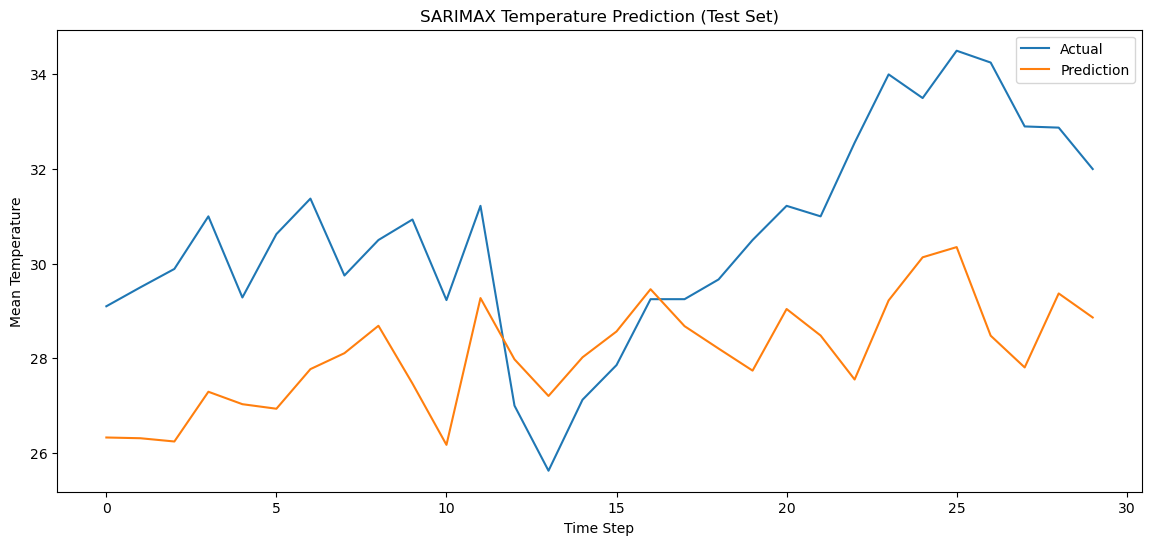

In [54]:
plt.figure(figsize=(14,6))
plt.plot(y_test.values, label='Actual')
plt.plot(forecast.values, label='Prediction')
plt.title("SARIMAX Temperature Prediction (Test Set)")
plt.xlabel("Time Step")
plt.ylabel("Mean Temperature")
plt.legend()
plt.show()

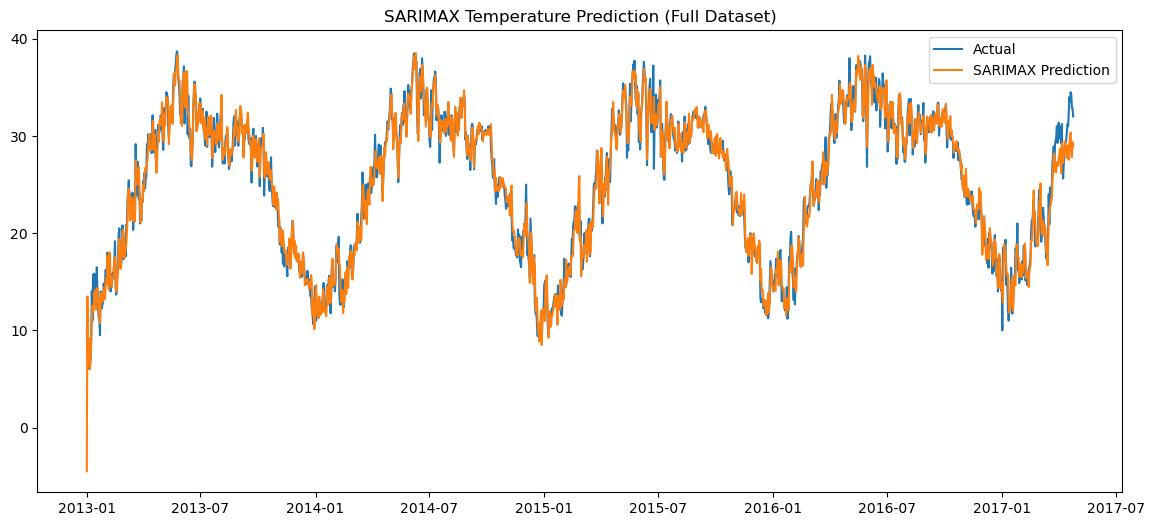

In [55]:
train_fitted = sarima_fit.fittedvalues


test_forecast = sarima_fit.forecast(
    steps=len(y_test),
    exog=X_test_scaled
)


full_prediction = pd.concat([
    pd.Series(train_fitted, index=train.index),
    pd.Series(test_forecast, index=test.index)
])


plt.figure(figsize=(14,6))
plt.plot(df.index, df['meantemp'], label='Actual')
plt.plot(full_prediction.index, full_prediction, label='SARIMAX Prediction')
plt.title("SARIMAX Temperature Prediction (Full Dataset)")
plt.legend()
plt.show()


# SARIMAX WITH 7 DAY SEASONLITY(1,0,1,7)

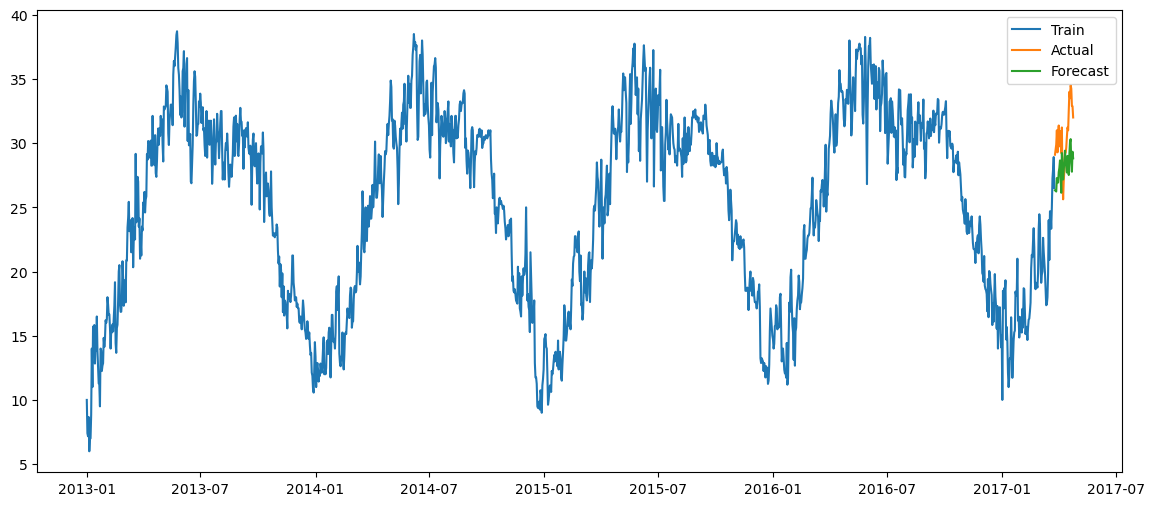

MAE: 2.798946005085061
RMSE: 3.139390033850461
R2: -1.1631525633133566


In [56]:
exog_cols = ['humidity', 'meanpressure', 'wind_speed']

train = df.iloc[:-30]
test  = df.iloc[-30:]

y_train = train['meantemp']
y_test  = test['meantemp']

X_train = train[exog_cols]
X_test  = test[exog_cols]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    y_train,
    exog=X_train_scaled,
    order=(1,1,1),
    seasonal_order=(1,0,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fit = model.fit(disp=False)

forecast = sarima_fit.forecast(
    steps=len(y_test),
    exog=X_test_scaled
)


plt.figure(figsize=(14,6))
plt.plot(train.index, y_train, label='Train')
plt.plot(test.index, y_test, label='Actual')
plt.plot(test.index, forecast, label='Forecast')
plt.legend()
plt.show()

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, forecast)
rmse = np.sqrt(mean_squared_error(y_test, forecast))
r2   = r2_score(y_test, forecast)

print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)


# SARIMAX WITH 7 DAY SEASONLITY(1,1,1,7)

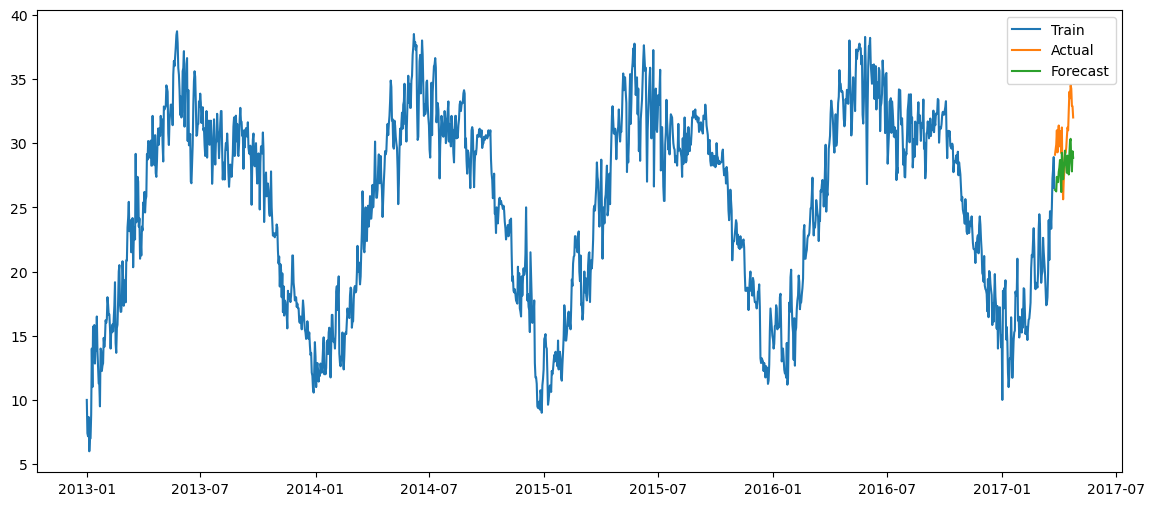

MAE: 2.775872112880783
RMSE: 3.116543257741998
R2: -1.1317826271521318


In [57]:
exog_cols = ['humidity', 'meanpressure', 'wind_speed']

train = df.iloc[:-30]
test  = df.iloc[-30:]

y_train = train['meantemp']
y_test  = test['meantemp']

X_train = train[exog_cols]
X_test  = test[exog_cols]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    y_train,
    exog=X_train_scaled,
    order=(1,1,1),
    seasonal_order=(1,1,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fit = model.fit(disp=False)

forecast = sarima_fit.forecast(
    steps=len(y_test),
    exog=X_test_scaled
)


plt.figure(figsize=(14,6))
plt.plot(train.index, y_train, label='Train')
plt.plot(test.index, y_test, label='Actual')
plt.plot(test.index, forecast, label='Forecast')
plt.legend()
plt.show()

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, forecast)
rmse = np.sqrt(mean_squared_error(y_test, forecast))
r2   = r2_score(y_test, forecast)

print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)


C:\Users\Kartikey Soni\.conda\envs\SIP_Project_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


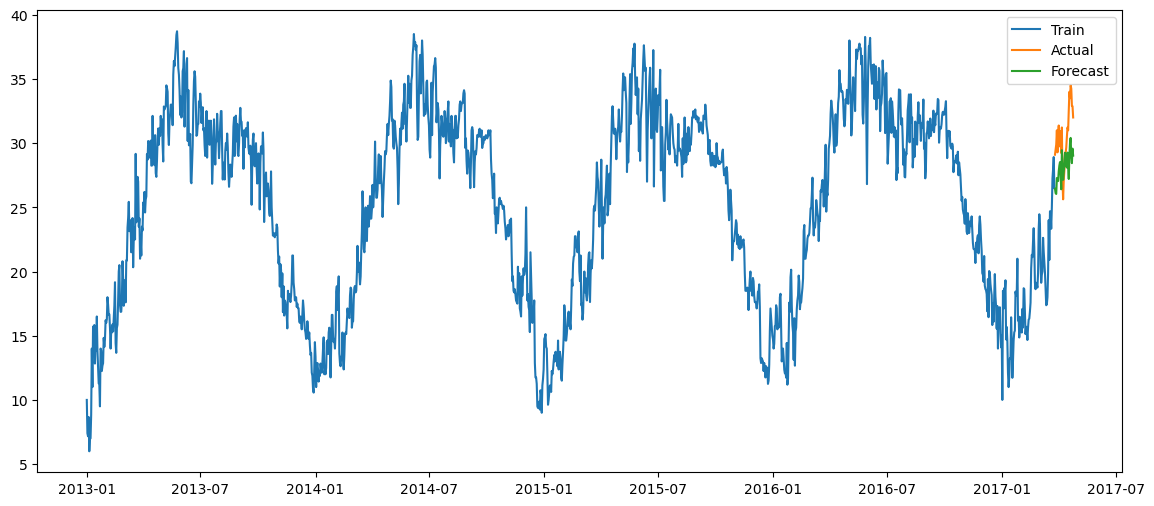

MAE: 2.707548925725044
RMSE: 3.0534361478023637


In [58]:
exog_cols = ['humidity', 'meanpressure', 'wind_speed']

train = df.iloc[:-30]
test  = df.iloc[-30:]

y_train = train['meantemp']
y_test  = test['meantemp']

X_train = train[exog_cols]
X_test  = test[exog_cols]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    y_train,
    exog=X_train_scaled,
    order=(1,1,1),
    seasonal_order=(1,1,1,30),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fit = model.fit(disp=False)

forecast = sarima_fit.forecast(
    steps=len(y_test),
    exog=X_test_scaled
)


plt.figure(figsize=(14,6))
plt.plot(train.index, y_train, label='Train')
plt.plot(test.index, y_test, label='Actual')
plt.plot(test.index, forecast, label='Forecast')
plt.legend()
plt.show()

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, forecast)
rmse = np.sqrt(mean_squared_error(y_test, forecast))

print("MAE:", mae)
print("RMSE:", rmse)
